In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import openpyxl
import time

In [3]:
if torch.backends.mps.is_available():
    print("MPS (Apple GPU) is available!")
else:
    print("MPS is not available.")

MPS (Apple GPU) is available!


In [4]:
device=torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


In [5]:
# set the rho here

In [6]:
class StressNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 6)
        )
    def forward(self, xyt):
        return self.net(xyt)

In [7]:
def body_force(x, y, t, e):
#    set the body forces fx and fy here Now fx=fy=0
    fx=torch.zeros_like(x)
    fy=torch.zeros_like(y)
    return fx, fy

In [8]:
def compute_dynamics_residual(model, x, y, t):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
#    set H (the thickness of a clay layer) and T (max time)

    xyt = torch.cat([x, y, t], dim=1).to(device)
    pred = model(xyt)
    sigma_xx, sigma_yy, sigma_xy, u, v, p = pred[:, [0]], pred[:, [1]], pred[:, [2]], pred[:, [3]], pred[:, [4]],pred[:,[5]]

    sigma_xx_x = torch.autograd.grad(sigma_xx, x, torch.ones_like(sigma_xx), create_graph=True)[0]
    sigma_xy_y = torch.autograd.grad(sigma_xy, y, torch.ones_like(sigma_xy), create_graph=True)[0]
    sigma_xy_x = torch.autograd.grad(sigma_xy, x, torch.ones_like(sigma_xy), create_graph=True)[0]
    sigma_yy_y = torch.autograd.grad(sigma_yy, y, torch.ones_like(sigma_yy), create_graph=True)[0]
    
    u_t = torch.autograd.grad(torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0],t, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0],t, torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0],t, torch.ones_like(v), create_graph=True)[0]
    v_tt = torch.autograd.grad(torch.autograd.grad(v_t, t, torch.ones_like(v_t), create_graph=True)[0],t, torch.ones_like(u), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True)[0]

# Updata the void ratio and Jaco here
# Call body_force to calculate fx,ty

# Updata x, y here


    r1 = sigma_xx_x + sigma_xy_y + p_x + fx - rho * jacobian * u_tt*H*T
    r2 = sigma_xy_x + sigma_yy_y + p_y + fy - rho * jacobian * v_tt*H*T
    return torch.mean(r1**2+r2**2)

In [9]:
def traction_boundary_loss(model):
    # Traction BC at y=0
    Nb=256
    yb=torch.zeros((Nb,1),device=device)
    xb=torch.rand((Nb,1),device=device)
    tb=torch.rand((Nb,1),device=device)
    xyt = torch.cat([xb, yb, tb], dim=1)
    sigma = model(xyt)
    sigma_xx, sigma_yy, sigma_xy,u,v,p = sigma[:, [0]], sigma[:, [1]], sigma[:, [2]],sigma[:, [3]],sigma[:, [4]],sigma[:, [5]]

    nx=torch.ones_like(xb)
    ny=torch.zeros_like(yb)
    tx=torch.zeros_like(xb)
    ty=torch.zeros_like(yb)
    pb=torch.zeros_like(yb)
    traction_x = sigma_xx * nx + sigma_xy * ny
    traction_y = sigma_xy * nx + sigma_yy * ny
    
    return nn.MSELoss()(traction_x, tx) + nn.MSELoss()(traction_y, ty)+nn.MSELoss()(p,pb)

def traction_boundary_loss2(model):
    # Traction BC at x=0
    Nb=256
    tb=torch.rand((Nb,1),device=device)
    zeros=torch.zeros_like(tb).to(device)
    ones=torch.ones_like(tb).to(device)
    loss=0
    for val in [zeros,ones]:
        xb = val
        yb = torch.rand_like(tb)
        xb.requires_grad_(True)
        yb.requires_grad_(True)
  
        xyt = torch.cat([xb,yb,tb],dim=1)
        sigma = model(xyt)
        sigma_xx, sigma_yy, sigma_xy,u,v,p = sigma[:, [0]], sigma[:, [1]], sigma[:, [2]],sigma[:, [3]],sigma[:, [4]],sigma[:, [5]]
        p_x = torch.autograd.grad(p, xb, torch.ones_like(p), create_graph=True)[0]

        loss += torch.mean(u**2+p_x**2)

    yb=ones
    xb=torch.rand_like(tb)
    xb.requires_grad_(True)
    yb.requires_grad_(True)
    xyt=torch.cat([xb,yb,tb],dim=1)
    sigma=model(xyt)
    sigma_xx, sigma_yy, sigma_xy,u,v,p = sigma[:, [0]], sigma[:, [1]], sigma[:, [2]],sigma[:, [3]],sigma[:, [4]],sigma[:, [5]]
    p_y = torch.autograd.grad(p, yb, torch.ones_like(p), create_graph=True)[0]
    loss +=torch.mean(v**2+p_y**2)
    
    return loss

def initial_condition_loss(model):
    # Initial condition: u(x, y, 0) = 0
    Ni=256
    xi = torch.rand((Ni, 1),device=device)
    yi = torch.rand((Ni, 1),device=device)
    ti = torch.zeros((Ni,1),device=device, requires_grad=True)
    xyt = torch.cat([xi, yi, ti], dim=1)
    u_pred = model(xyt)
    u,v,p=u_pred[:,[3]],u_pred[:,[4]],u_pred[:,[5]]
    u_t=torch.autograd.grad(u,ti,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    v_t=torch.autograd.grad(v,ti,grad_outputs=torch.ones_like(v),create_graph=True)[0]
    return torch.mean(u**2+v**2+u_t**2+v_t**2+(p-0.0001*981*yi)**2)

In [10]:
def total_loss(model,x,y,t):
    return (compute_dynamics_residual(model,x,y,t)+traction_boundary_loss(model)+traction_boundary_loss2(model)+initial_condition_loss(model))

In [11]:
def train(model,epochs=10001,lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        # Interior points
        Nf = 1024
        x_f = torch.rand((Nf, 1), device=device,requires_grad=True)
        y_f = torch.rand((Nf, 1), device=device,requires_grad=True)
        t_f = torch.rand((Nf, 1), device=device,requires_grad=True)
        
        loss = total_loss(model,x_f,y_f,t_f)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

    return model

In [12]:
def predict(model, t_val=0.093):
    x=torch.linspace(0,1,100)
    y=torch.linspace(0,1,100)
    grid_x,grid_y= torch.meshgrid(x,y,indexing='ij')
    grid_t=torch.full_like(grid_x,t_val)

    xyt = torch.cat([grid_x.reshape(-1,1), grid_y.reshape(-1,1), grid_t.reshape(-1,1)], dim=1).to(device)

    with torch.no_grad():
        sigma_pred = model(xyt)
        sigma_xx = sigma_pred[:, 0].reshape(100, 100).cpu().numpy()
        sigma_yy = sigma_pred[:, 1].reshape(100, 100).cpu().numpy()
        sigma_xy = sigma_pred[:, 2].reshape(100, 100).cpu().numpy()
        u = sigma_pred[:, 3].reshape(100, 100).cpu().numpy()
        v = sigma_pred[:, 4].reshape(100, 100).cpu().numpy()
        p=sigma_pred[:,5].reshape(100,100).cpu().numpy()

    return grid_x.cpu().numpy(), grid_y.cpu().numpy(), sigma_xx, sigma_yy, sigma_xy,u,v,p

In [13]:
def plot_field(X, Y, field, title):
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, field, levels=50, cmap='RdBu')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

Epoch    0 | Loss: 1.568e-01
Epoch  500 | Loss: 6.872e-05
Epoch 1000 | Loss: 7.172e-05
Epoch 1500 | Loss: 7.143e-05
Epoch 2000 | Loss: 9.504e-05
Epoch 2500 | Loss: 7.426e-05
Epoch 3000 | Loss: 3.872e-05
Epoch 3500 | Loss: 2.438e-05
Epoch 4000 | Loss: 2.263e-05
Epoch 4500 | Loss: 2.250e-05
Epoch 5000 | Loss: 2.367e-05
Epoch 5500 | Loss: 3.201e-05
Epoch 6000 | Loss: 1.760e-05
Epoch 6500 | Loss: 1.255e-05
Epoch 7000 | Loss: 1.572e-05
Epoch 7500 | Loss: 1.345e-05
Epoch 8000 | Loss: 1.500e-05
Epoch 8500 | Loss: 1.143e-05
Epoch 9000 | Loss: 1.038e-05
Epoch 9500 | Loss: 1.445e-05
Epoch 10000 | Loss: 1.185e-05


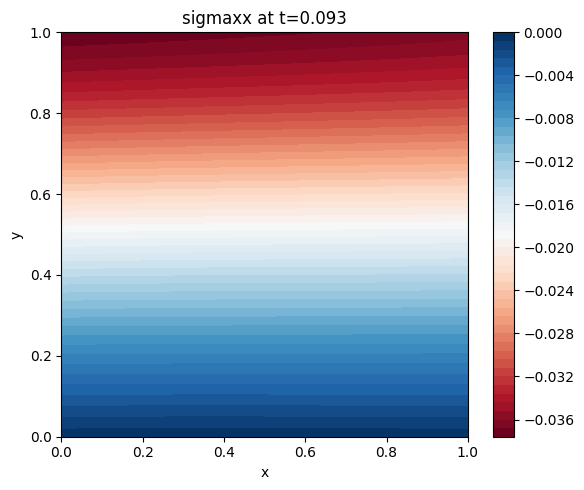

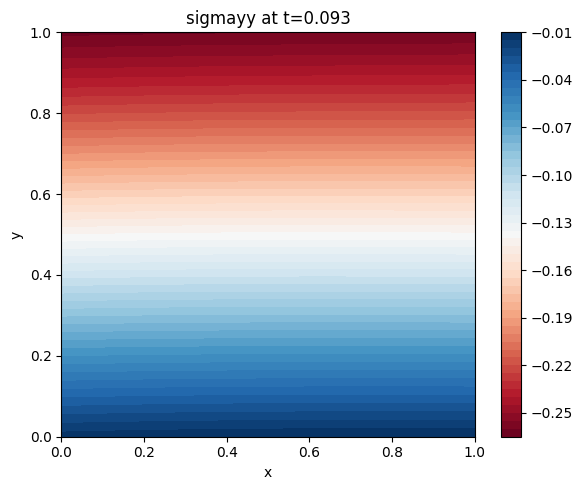

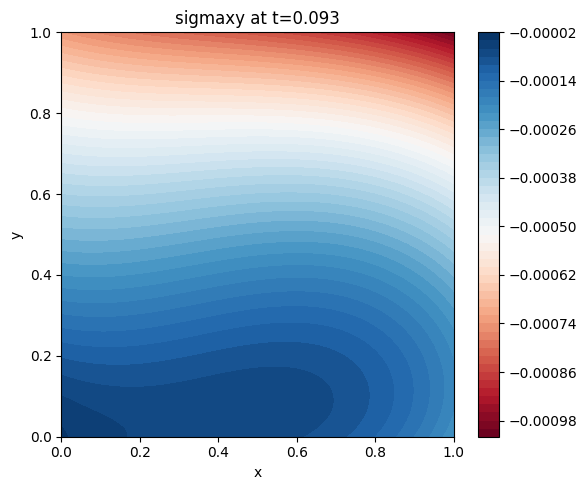

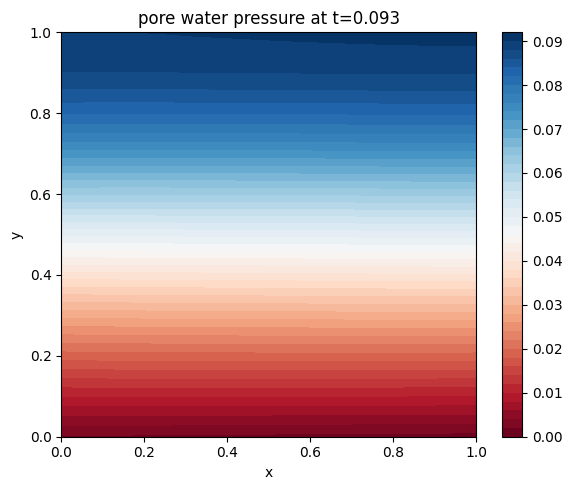

GPU time 1299.659995317459  seconds
Saved


In [14]:
if __name__=="__main__":
    model=StressNet().to(device)
    torch.mps.synchronize()
    start=time.time()
    train(model)
    x,y,sigmaxx,sigmayy,sigmaxy,uu,vv,pp=predict(model,t_val=0.045)
    plot_field(x,y,sigmaxx,"sigmaxx at t=0.093")
    plot_field(x,y,sigmayy,"sigmayy at t=0.093")
    plot_field(x,y,sigmaxy,"sigmaxy at t=0.093")
    plot_field(x,y,pp,"pore water pressure at t=0.093")
    end=time.time()
    print("GPU time",end-start," seconds")
    print('Saved')